In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import cho_factor, cho_solve
from scipy.stats import weightedtau

from scripts.utils import listfiles
from subprocess import *

%matplotlib inline

In [73]:
figOutputDirectory = "../informe/imagenes/"

# Elo

In [2]:
# implementando elo
# https://www.geeksforgeeks.org/elo-rating-algorithm/


def ELOProbability(rating1, rating2): 
    return 1.0 * 1.0 / (1 + 1.0 * math.pow(10, 1.0 * (rating1 - rating2) / 400)) 

def ELORating(Ra, Rb, d):

    K = 30

    Pb = ELOProbability(Ra, Rb)
    Pa = ELOProbability(Rb, Ra)

    # gana A
    if (d == 1) :
        Ra = Ra + K * (1 - Pa)
        Rb = Rb + K * (0 - Pb)
    # gana B
    else :
        Ra = Ra + K * (0 - Pa)
        Rb = Rb + K * (1 - Pb)

    return (round(Ra, 6), round(Rb, 6))

In [3]:
# generando dataframe para el ranking utilizando elo

table_names=['date', 'eq1', 'sc1', 'eq2', 'sc2']
atp_df = pd.read_table("../data/atp_matches_2015.dat", delimiter=' ', names=table_names)[1:]

atp_teams = pd.concat([atp_df.eq1, atp_df.eq2], axis=0).unique()
elo_rating = np.repeat(1500, len(atp_teams))

elo_df = pd.DataFrame(data={'id': atp_teams, 'elo': elo_rating})

for i, row in atp_df.iterrows():
    elo_eq1 = elo_df[elo_df.id==row.eq1].elo.iloc[0]
    elo_eq2 = elo_df[elo_df.id==row.eq2].elo.iloc[0]

    (elo_eq1, elo_eq2) = ELORating(elo_eq1, elo_eq2, row.sc1)

    elo_df.at[elo_df.id==row.eq1, "elo"] = elo_eq1
    elo_df.at[elo_df.id==row.eq2, "elo"] = elo_eq2

# Comparación

In [69]:
# generar csv para cmm y wp

!python metnum.py build;
!./tp ../data/atp_matches_2015.dat ../data/atp_matches_2015_CMM.out 0 ../data/atp_matches_2015_CMM.csv
!./tp ../data/atp_matches_2015.dat ../data/atp_matches_2015_WP.out 1 ../data/atp_matches_2015_WP.csv

resultados = pd.DataFrame()

cmm_df = pd.read_csv("../data/atp_matches_2015_CMM.csv").rename({'rating': 'CMM'}, axis=1)
resultados = cmm_df[['id', 'ganados', 'perdidos', 'jugados', 'CMM']].set_index("id")
wp_df = pd.read_csv("./prueba-wp.csv")[['id', 'rating']].rename({'rating': 'WP'}, axis=1)

resultados = resultados.join(wp_df.set_index("id"), on="id").join(elo_df.set_index("id"), on="id")
        
resultados

,ganados,perdidos,jugados,CMM,WP,elo
id,,,,,,
104527,55,19,74,1.036890,0.743243,1786.598025
103285,7,10,17,0.586419,0.411765,1487.023086
105147,8,12,20,0.532892,0.400000,1453.015795
106415,3,5,8,0.490583,0.375000,1480.681495
105572,7,11,18,0.582256,0.388889,1456.987723
...,...,...,...,...,...,...
127570,0,1,1,0.377427,0.000000,1485.598515
200537,1,0,1,0.625000,1.000000,1515.000000
118591,0,1,1,0.375000,0.000000,1485.000000


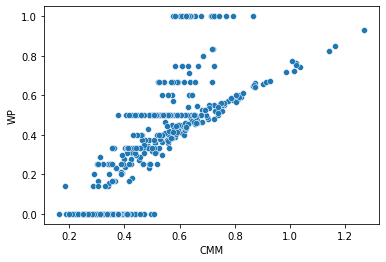

In [74]:
sns.scatterplot(x=resultados['CMM'], y=resultados['WP'])
plt.savefig(f"{figOutputDirectory}scatterplot_CMM_WP.png")

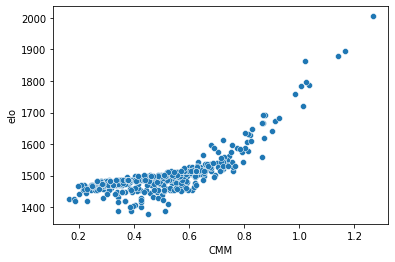

In [75]:
sns.scatterplot(x=resultados['CMM'], y=resultados['elo'])
plt.savefig(f"{figOutputDirectory}scatterplot_CMM_Elo.png")

In [72]:
resultados[['CMM', 'WP', 'elo']].corr()

,CMM,WP,elo
CMM,1.000000,0.805171,0.788608
WP,0.805171,1.000000,0.514039
elo,0.788608,0.514039,1.000000


In [9]:
print("CMM vs WP: ", weightedtau(x=resultados['CMM'], y=resultados['WP']))
print("CMM vs Elo: ", weightedtau(x=resultados['CMM'], y=resultados['elo']))

CMM vs WP:  WeightedTauResult(correlation=0.7633313528479408, pvalue=nan)
CMM vs Elo:  WeightedTauResult(correlation=0.8682893703447636, pvalue=nan)


# "Famosos" dentro de los mejores rankeados

In [10]:
atp_players = pd.read_csv("../data/atp_players.csv").set_index('id')

atp_players = atp_players.join(resultados, on="id") #agrego los ratings
atp_players.dropna(subset=['CMM'], inplace=True) #drop todos los que no tienen CMM (i.e. no jugaron)

cmm_sorted = atp_players.sort_values('CMM', ascending = False).reset_index()
cmm_sorted.head(10)

,id,first_name,last_name,hand,birth_date,country_code,ganados,perdidos,jugados,CMM,WP,elo
0,104925,Novak,Djokovic,R,19870522.0,SRB,83.0,6.0,89.0,1.267230,0.932584,2005.133248
1,103819,Roger,Federer,R,19810808.0,SUI,63.0,11.0,74.0,1.164020,0.851351,1893.504456
2,104918,Andy,Murray,R,19870515.0,GBR,71.0,15.0,86.0,1.141130,0.825581,1877.870555
3,104527,Stanislas,Wawrinka,R,19850328.0,SUI,55.0,19.0,74.0,1.036890,0.743243,1786.598025
4,105453,Kei,Nishikori,R,19891229.0,JPN,55.0,17.0,72.0,1.022890,0.763889,1797.867083
5,104745,Rafael,Nadal,L,19860603.0,ESP,61.0,20.0,81.0,1.020910,0.753086,1864.673407
6,104607,Tomas,Berdych,R,19850917.0,CZE,57.0,22.0,79.0,1.013320,0.721519,1721.469899
7,103970,David,Ferrer,R,19820402.0,ESP,55.0,16.0,71.0,1.005880,0.774648,1785.635399
8,104755,Richard,Gasquet,R,19860618.0,FRA,43.0,17.0,60.0,0.985301,0.716667,1758.993443
9,105683,Milos,Raonic,R,19901227.0,CAN,33.0,16.0,49.0,0.927979,0.673469,1681.733907


In [11]:
elo_sorted = atp_players.sort_values('elo', ascending = False).reset_index()
elo_sorted.head(10)

,id,first_name,last_name,hand,birth_date,country_code,ganados,perdidos,jugados,CMM,WP,elo
0,104925,Novak,Djokovic,R,19870522.0,SRB,83.0,6.0,89.0,1.267230,0.932584,2005.133248
1,103819,Roger,Federer,R,19810808.0,SUI,63.0,11.0,74.0,1.164020,0.851351,1893.504456
2,104918,Andy,Murray,R,19870515.0,GBR,71.0,15.0,86.0,1.141130,0.825581,1877.870555
3,104745,Rafael,Nadal,L,19860603.0,ESP,61.0,20.0,81.0,1.020910,0.753086,1864.673407
4,105453,Kei,Nishikori,R,19891229.0,JPN,55.0,17.0,72.0,1.022890,0.763889,1797.867083
5,104527,Stanislas,Wawrinka,R,19850328.0,SUI,55.0,19.0,74.0,1.036890,0.743243,1786.598025
6,103970,David,Ferrer,R,19820402.0,ESP,55.0,16.0,71.0,1.005880,0.774648,1785.635399
7,104755,Richard,Gasquet,R,19860618.0,FRA,43.0,17.0,60.0,0.985301,0.716667,1758.993443
8,104607,Tomas,Berdych,R,19850917.0,CZE,57.0,22.0,79.0,1.013320,0.721519,1721.469899
9,106058,Jack,Sock,R,19920924.0,USA,35.0,18.0,53.0,0.874580,0.660377,1693.285410


In [12]:
wp_sorted = atp_players.sort_values('WP', ascending = False).reset_index()
wp_sorted.head(10)

,id,first_name,last_name,hand,birth_date,country_code,ganados,perdidos,jugados,CMM,WP,elo
0,200537,Nicolas,Xiviller,NaN,19981111.0,URU,1.0,0.0,1.0,0.625000,1.0,1515.000000
1,125571,Christian,Garay,U,19960218.0,PUR,2.0,0.0,2.0,0.677645,1.0,1528.708005
2,106249,Joao,Domingues,U,19931005.0,POR,1.0,0.0,1.0,0.625000,1.0,1515.000000
3,105464,Christopher,Rungkat,R,19900114.0,INA,1.0,0.0,1.0,0.637893,1.0,1515.000000
4,105334,Luis David,Martinez,U,19890512.0,VEN,1.0,0.0,1.0,0.575252,1.0,1514.352800
5,106237,Chieh Fu,Wang,U,19930911.0,TPE,2.0,0.0,2.0,0.766782,1.0,1530.749337
6,106426,Christian,Garin,R,19960530.0,CHI,3.0,0.0,3.0,0.722988,1.0,1542.471394
7,108717,Francis Casey,Alcantara,U,19920204.0,PHI,1.0,0.0,1.0,0.625000,1.0,1515.000000
8,108780,Lofo,Ramiaramanana,U,19890614.0,MAD,1.0,0.0,1.0,0.620004,1.0,1515.000000
9,105790,Yong Kyu,Lim,U,19910618.0,KOR,1.0,0.0,1.0,0.605828,1.0,1515.000000


In [62]:
ranking_posta = [(1,"Djokovic"), (2,"Murray"), (3,"Federer"), (4,"Wawrinka"), (5,"Nadal"), (6,"Berdych"), (7,"Ferrer"), (8,"Nishikori"), (9,"Gasquet"), (10,"Tsonga"), (14, "Raonic")]
realRankDF = pd.DataFrame(ranking_posta, columns = ['rank','last_name']).set_index('rank')
realRankDF

,last_name
rank,
1,Djokovic
2,Murray
3,Federer
4,Wawrinka
5,Nadal
6,Berdych
7,Ferrer
8,Nishikori
9,Gasquet


In [65]:
cmmHead = cmm_sorted.head(10)[['id', 'first_name', 'last_name']].copy()


eloRank = []
wpRank = []
realRank = []
for index, info in cmmHead.iterrows():
    eloRank.append(elo_sorted[elo_sorted.id == info.id].index[0]+1)
    wpRank.append(wp_sorted[wp_sorted.id == info.id].index[0]+1)
    realRank.append(realRankDF[realRankDF.last_name == info.last_name].index[0])
    
cmmHead['CMM_rank'] = range(1, 11)    
cmmHead['Elo_rank'] = eloRank
cmmHead['WP_rank'] = wpRank
cmmHead['Ranking_real'] = realRank

cmmHead.to_csv("../informe/csvs/tops10.csv", index=False)
cmmHead

,id,first_name,last_name,CMM_rank,Elo_rank,WP_rank,Ranking_real
0,104925,Novak,Djokovic,1,1,27,1
1,103819,Roger,Federer,2,2,28,3
2,104918,Andy,Murray,3,3,31,2
3,104527,Stanislas,Wawrinka,4,6,41,4
4,105453,Kei,Nishikori,5,5,34,8
5,104745,Rafael,Nadal,6,4,35,5
6,104607,Tomas,Berdych,7,9,42,6
7,103970,David,Ferrer,8,7,33,7
8,104755,Richard,Gasquet,9,8,43,9
9,105683,Milos,Raonic,10,12,45,14


# Outliers de CMM vs WP

<AxesSubplot:xlabel='CMM', ylabel='WP'>

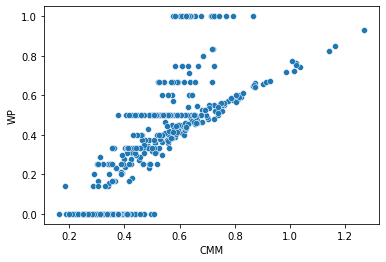

In [77]:
sns.scatterplot(x=resultados['CMM'], y=resultados['WP'])

In [84]:
resultados[resultados.WP.isin([0,0.5,1])] #Los outliers en wp son 0, 0.5 y 1

,ganados,perdidos,jugados,CMM,WP,elo
id,,,,,,
106034,0,2,2,0.333521,0.0,1472.546509
104871,27,27,54,0.738143,0.5,1553.226772
105238,26,26,52,0.694004,0.5,1503.422159
144707,0,1,1,0.375624,0.0,1485.000000
109739,0,2,2,0.331337,0.0,1469.939881
...,...,...,...,...,...,...
127570,0,1,1,0.377427,0.0,1485.598515
200537,1,0,1,0.625000,1.0,1515.000000
118591,0,1,1,0.375000,0.0,1485.000000
